In [1]:
# IMPORT PACKAGES
from package_bfry import *

/Users/brianfry/Documents/GitHub/Bologna/package_bfry/bfry.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_2019['Area Statistica'] = income_2019['Area Statistica'].str.upper()


In [ ]:
# HOUSEHOLD SIZE
# map the household size
base_map_2019.explore(column = 'avg_household_size', cmap = 'RdBu_r', tooltip = ('zona_fiu', 'population', 'households', 'avg_household_size'), 
                                          tiles = 'CartoDB positron', legend=True)

In [ ]:
# airbnb #
# base dataset : airbnb_agg

create_map(base_map_2019, airbnb_agg, 'household', 'airbnb', airbnb)

In [ ]:
# WIFI #
# base dataset : wifi_agg

# map the wifi per capita
create_map(base_map_2019, wifi_agg, 'population', 'hotspot', wifi, quotient = 1000)

In [ ]:
# PARTICIPATORY BUDGET #
# base dataset : budg_geo

    # process data for mapping
# aggregate the count of participative budget projects at the neighborhood level
# TO DO - resolve mixed geometry situation
#budg_agg = 
#gpd.overlay(base_map_2019, budg_geo, how='intersection', keep_geom_type=False) #.groupby('cod_zona').count()
#budg_agg
# rename and subset the data just to the count of the projects per neighborhood
#budg_agg = budg_agg.rename(columns={'Progetto':'project_count'})['project_count']
budg_geo.explore()
    # map the data
#create_map(base_map_2019, budg_agg, 'population', 'project', budg_geo, quotient = 1000)

In [ ]:
# STREET FURNITURE #
# base dataset : furniture
furniture_state_2019

In [74]:
    # bike lanes
# base dataset : bike_lanes
# limit to the earliest bike lanes possible
# *** NOT AVAILABLE FOR 2019 ? ***
bike_lanes = bike_lanes[bike_lanes['anno'] == 'Precedente 31/12/2021']
#bike_lanes.explore(column = 'dtipologia2')
# sum up all bike lanes by zone
length_all_bike_lanes = bike_lanes.groupby(['zona_fiu'])['length'].sum().to_frame().reset_index().set_index('zona_fiu').rename(columns={'length':'length_all_bike_m'})

# sum bike lanes by type 
length_bike_lanes_grouped = bike_lanes.groupby(['zona_fiu','dtipologia2'])['length'].sum().to_frame().reset_index().set_index('zona_fiu')

# sum up the length of bike lanes that are "most safe"
    # to verify if these are the best to choose? 
    # i made a decision based on my personal feelings, maybe there is a more rigorous standard to follow
length_safe_bike_lanes = length_bike_lanes_grouped[length_bike_lanes_grouped['dtipologia2'].isin(['sede propria', 'ciclabile contigua al pedonale', 
                                                                                                       'promiscuo ciclopedonale', 'area pedonale', 'pavimentato',
                                                                                                       'sterrato'])].groupby(['zona_fiu'])['length'].sum().to_frame().rename(columns={'length':'length_safe_bike_m'})


In [82]:
# join the bike lanes data and calculate bike lane length per capita and percent "safe" lanes
transport_2019 = transport_2019.join(length_all_bike_lanes)
transport_2019 = transport_2019.join(length_safe_bike_lanes)
transport_2019['bike_m_per_capita'] = round(transport_2019['length_all_bike_m']/transport_2019['population'],4)
transport_2019['percent_safe_bike'] = round((transport_2019['length_safe_bike_m']/transport_2019['length_all_bike_m'])*100,0)

In [94]:
# explore traffic per capita at the zone level
transport_2019.explore(column = 'traffic_per_1000', cmap = 'RdBu_r')
# also calculate incident standardized by traffic level
transport_2019['incident_per_traffic'] = transport_2019['n_incident']/transport_2019['avg_daily_traffic']

In [ ]:
# explore bike parking per capita / household
transport_2019.explore(column = 'bike_parking_per_household', cmap = 'RdBu_r')

In [ ]:
# explore bus stops per capita
transport_2019.explore(column = 'tper_stops_per_1000', cmap = 'RdBu_r')

In [95]:
# MULTI VARIABLE ANALYSIS #
    # create a dataframe of variables to be analyzed together
    # can add or remove metrics for analysis as needed
df = transport_2019[['population', 'avg_income',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size', 'traffic_per_1000', 'incident_per_1000', 'injured_per_incident', 'incident_per_traffic', 'bike_parking_per_household',
       'tper_stops_per_1000']]

In [ ]:
# plot the distribution for each variable to explore variation
for column in df:
    df[[column]].plot.hist()

In [ ]:
# examine the relationship between bike parking per household vs per capita
df.plot(x='bike_parking_per_household', y='bike_parking_per_1000', style='o')
# it's a straight line - doesn't seem to matter which one is used

In [92]:
# calculate the number of traffic coils per zone to determine the adequacy of this measurement 
base_map_2019.join(traffic_2019_geo.sjoin(base_map_2019[['geometry']]).groupby('index_right')['day_total_traffic'].count()).explore(column = 'day_total_traffic', tooltip= ('day_total_traffic'), cmap = 'RdBu_r')

In [5]:
    # calculate the z-score to give a more standard frame of rereference across metrics
df_z = (df - df.mean())/df.std()
df_z = df_z.fillna(0)

    # create a subset of just base/socioecon related metrics
df_z_socioecon = df_z[['population', 'avg_income',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size']]

    # create a subset of just transport related metrics
df_z_transport = df_z[['traffic_per_1000',
       'incident_per_1000', 'injured_per_incident',
       'bike_parking_per_household', 'tper_stops_per_1000']]

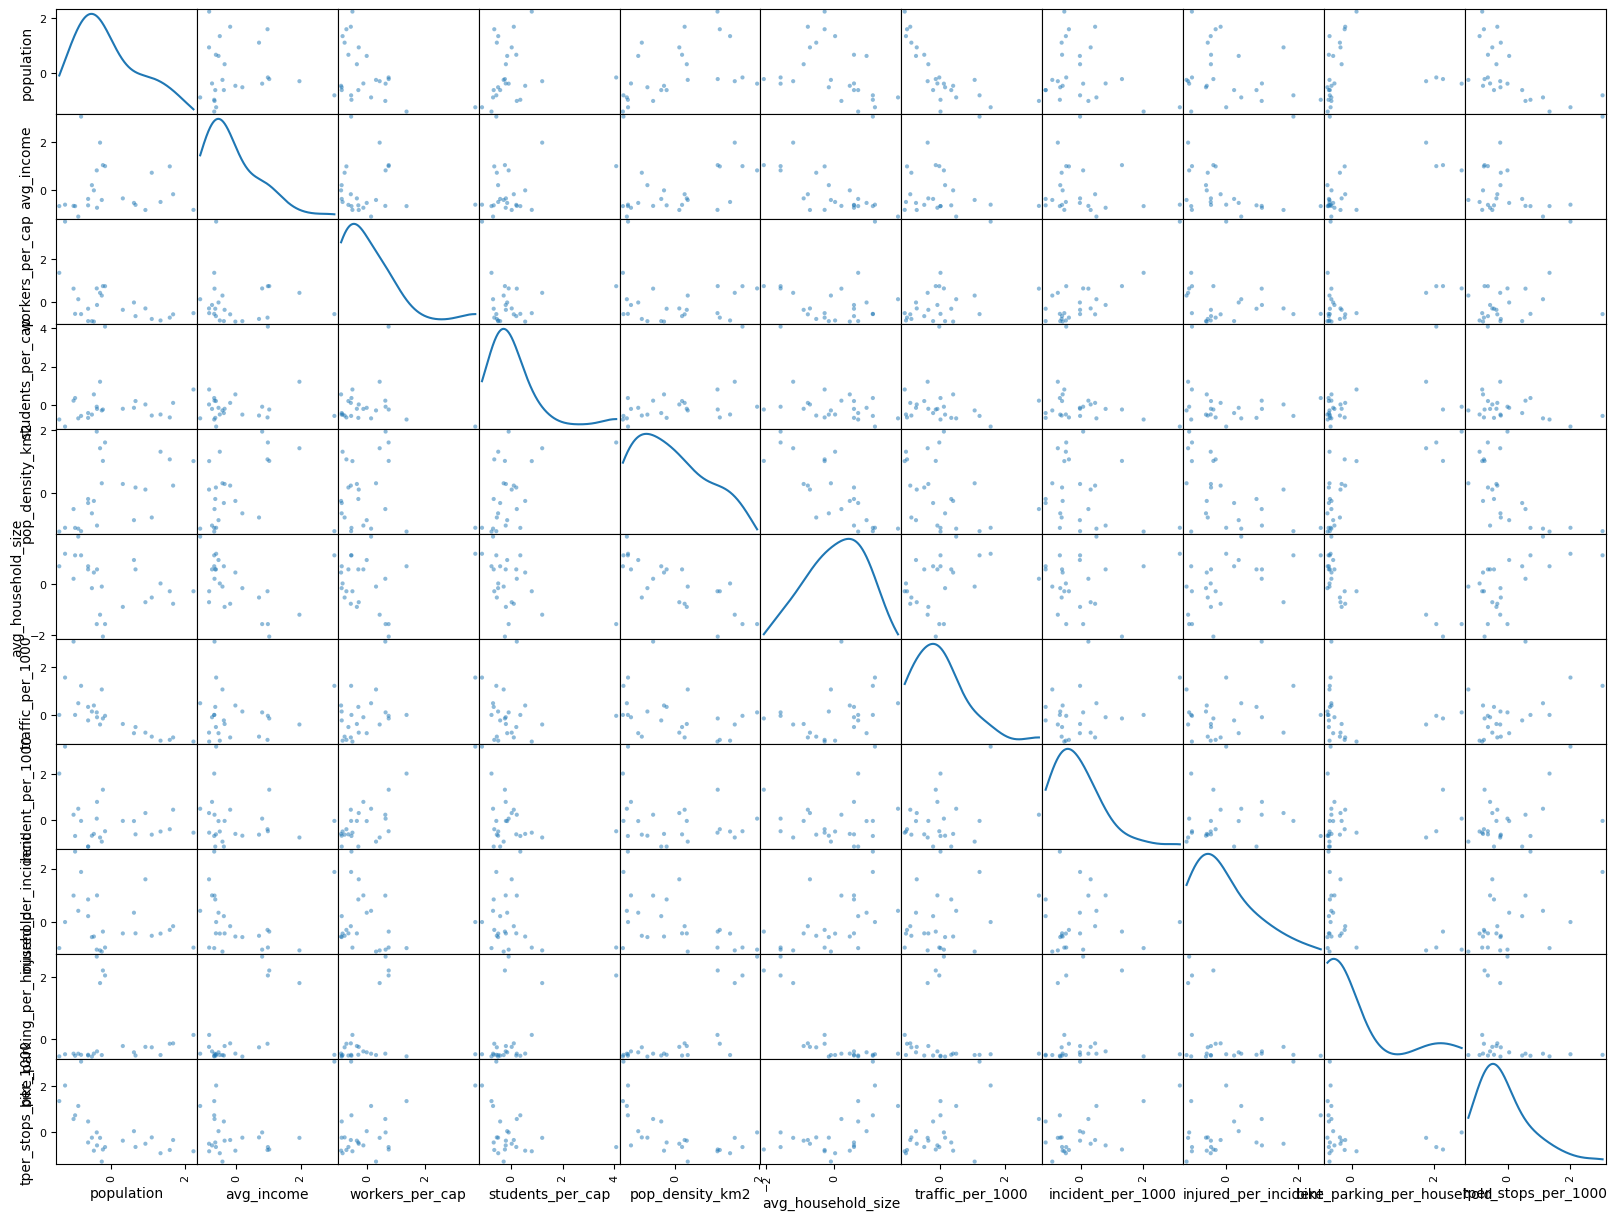

In [93]:
# scattter matrix to view distributions and correlations together
pd.plotting.scatter_matrix(df_z.loc[:, 'population':'tper_stops_per_1000'], diagonal="kde",figsize=(20,15))
plt.show()
#df_z
#hinton(df_z.corr())
#df_z.corr()

Text(0, 0.5, 'SSE')

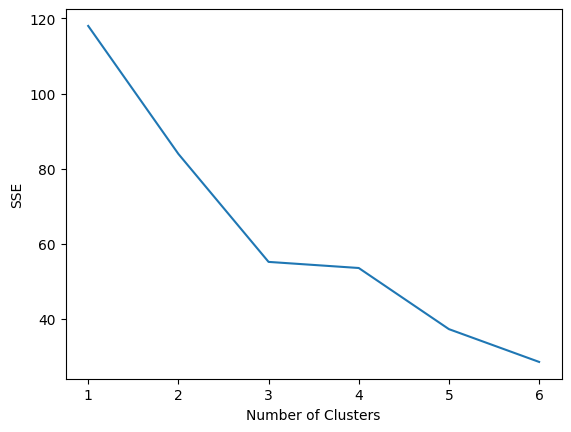

In [21]:
# test for best number of clusters
    # should use n-1 where n is the "elbow" of the plot where slope significantly changes
import matplotlib.pyplot as plt
%matplotlib inline

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(df_z_transport)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [13]:
# create a cluster class instance using the df_z dataframe, and categorizing into 3 clusters, and having a geo-dataframe that has each zone polygon with its cluster
df_z_clusters_3 = km_cluster_analysis(df_z, 3, base_map_2019)

In [14]:
# display the map of the zones showing the clusters by color and limiting the tooltip to avoid noisy visualization
df_z_clusters_3.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))

In [15]:
# display the average z-score for each metric across each cluster
# this tells about the character of each cluster
# for interpretation: a more negative/positive number means a cluster is characterized by being more below/above the average across all zones
df_z_clusters_3.centroids

,population,avg_income,workers_per_cap,students_per_cap,pop_density_km2,avg_household_size,traffic_per_1000,incident_per_1000,injured_per_incident,bike_parking_per_household,tper_stops_per_1000,incident_per_traffic
0,-0.407585,-0.129433,-0.347648,-0.131473,-0.523246,0.556267,0.420850,-0.425206,0.475209,-0.515688,0.088154,-0.607545
1,0.732319,0.346303,-0.128955,0.365324,0.842038,-0.901374,-0.607518,-0.093938,-0.423095,0.659217,-0.494873,0.624087
2,-1.190693,-0.795190,1.747546,-0.857454,-1.168903,1.265390,0.684450,1.903528,-0.191086,-0.526275,1.491303,-0.060657


In [18]:
# repeat the above analysis but use 4 zones
df_z_clusters_4 = km_cluster_analysis(df_z, 4, base_map_2019)
df_z_clusters_4.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))

In [25]:
# display the centroids for the 4-cluster analysis of all metrics
df_z_clusters_4.centroids

,population,avg_income,workers_per_cap,students_per_cap,pop_density_km2,avg_household_size,traffic_per_1000,incident_per_1000,injured_per_incident,bike_parking_per_household,tper_stops_per_1000,incident_per_traffic
0,-0.407585,-0.129433,-0.347648,-0.131473,-0.523246,0.556267,0.420850,-0.425206,0.475209,-0.515688,0.088154,-0.607545
1,1.308796,-0.141386,-0.571126,-0.134809,0.462358,-0.494553,-0.886334,-0.176539,-0.174295,-0.217820,-0.548905,1.081015
2,-1.190693,-0.795190,1.747546,-0.857454,-1.168903,1.265390,0.684450,1.903528,-0.191086,-0.526275,1.491303,-0.060657
3,-0.276516,1.199759,0.644842,1.240556,1.506479,-1.613310,-0.119590,0.050614,-0.858494,2.194032,-0.400318,-0.175536


In [20]:
# perform 4-cluster analysis on df_z_socioecon (socioecon metrics only) and display results
df_socio_clusters_4 = km_cluster_analysis(df_z_socioecon, 4, base_map_2019)
df_socio_clusters_4.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))

# interesting result: zone Beverara is the only zone that has changed. indicates that this zone is more similar to zone 2 socioeconomically speaking but more similar to 0 when considering the transportation metrics

In [24]:
# display the centroids for the 4-cluster analysis of just socioeconomic metrics
df_socio_clusters_4.centroids

,population,avg_income,workers_per_cap,students_per_cap,pop_density_km2,avg_household_size
0,-0.345612,-0.076214,-0.445765,-0.167149,-0.523594,0.590598
1,1.308796,-0.141386,-0.571126,-0.134809,0.462358,-0.494553
2,-1.149848,-0.761799,1.469040,-0.586768,-1.006619,1.002283
3,-0.276516,1.199759,0.644842,1.240556,1.506479,-1.613310


In [29]:
# perform cluster analysis on df_z_transport (transport metrics only) and display results
# screeplot (the "elbow" graph) analysis of this dataset yielded a result that suggested 2 clusters was most meaningful 
df_transport_clusters_2 = km_cluster_analysis(df_z_transport, 2, base_map_2019)
df_transport_clusters_2.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))
# should try to add more transportation related metrics and determine if this creates more meaningful insight

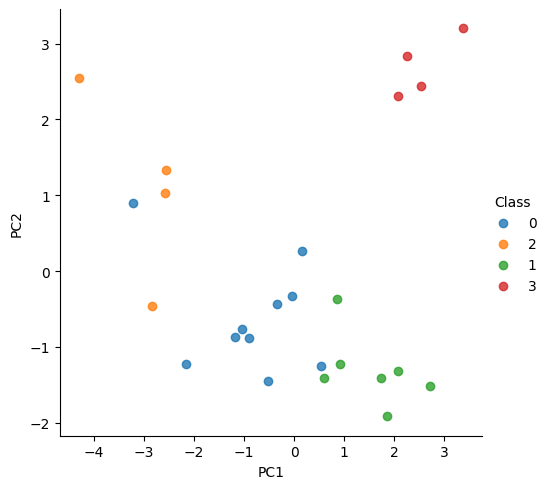

In [91]:
    # principal compoenents analysis
# set the resulting categories of the cluster analysis as dependent variable 
y = list(df_socio_clusters_4.geo['Cluster ID'])

# define the principal component analysis from the standardized z-score data
pca = PCA().fit(df_z)

# output the summary statistics for each principal component
#pca_summary(pca, df_z)

# display the coefficients for the first principal component
#pca.components_[0]

# display the screeplot to determine the number of principal components to retain
# should use n-1 where n is where the "elbow" of the plot occurs - where the slope significantly changes
#screeplot(pca, df_z) 
    # based on result - retain the first 3 principal components

# display a scatterplot of the data to show the clusters in comparison to the first two principal components
pca_scatter(pca, df_z, y)
# the PCA analysis and the cluster analysis appear compatible

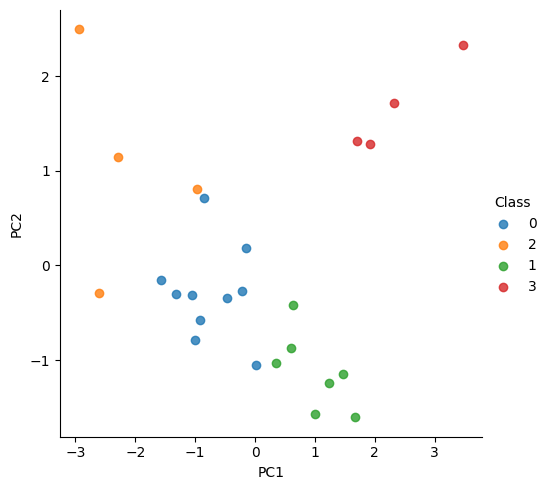

In [28]:
# repeat the analysis with the socioeconomic metrics
y_socioecon = list(df_socio_clusters_4.geo['Cluster ID'])
pca_socioecon = PCA().fit(df_z_socioecon)
pca_scatter(pca_socioecon, df_z_socioecon, y_socioecon)

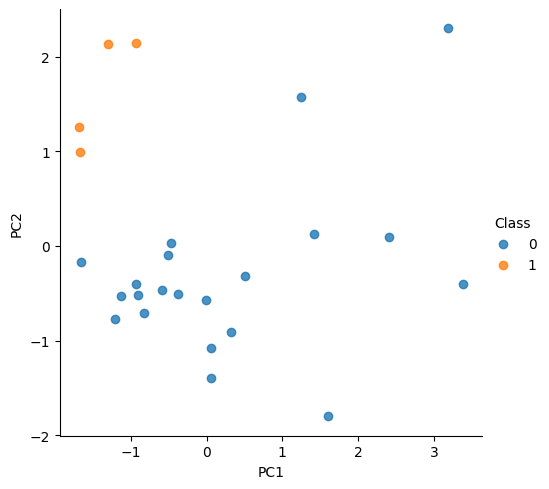

In [30]:
# repeat the analysis with the transport metrics
y_transport = list(df_transport_clusters_2.geo['Cluster ID'])
pca_transport = PCA().fit(df_z_transport)
pca_scatter(pca_transport, df_z_transport, y_transport)

# conclusion as of 19/7 - the analysis of the combined dataset is still being driven heavily by the summary statistics 
# removing the summary stats leads to a weak grouping from the transport related metrics into two clusters - interior and exterior
# continue adding metrics

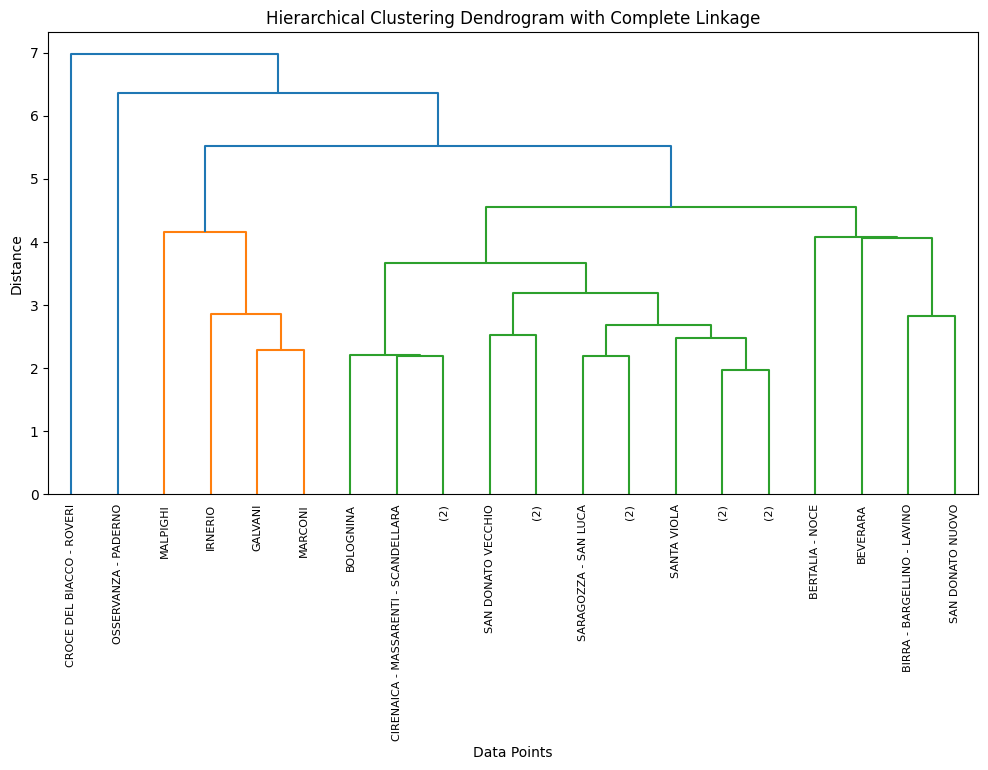

In [31]:
# hierarchical clustering - provides ability to see further granularity and inter-group similarities / differences compared to k-means

# average linkage - compares using average distance between members of each cluster
linkage_matrix = linkage(df_z, method='average', metric='euclidean')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True, labels=df_z.index)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

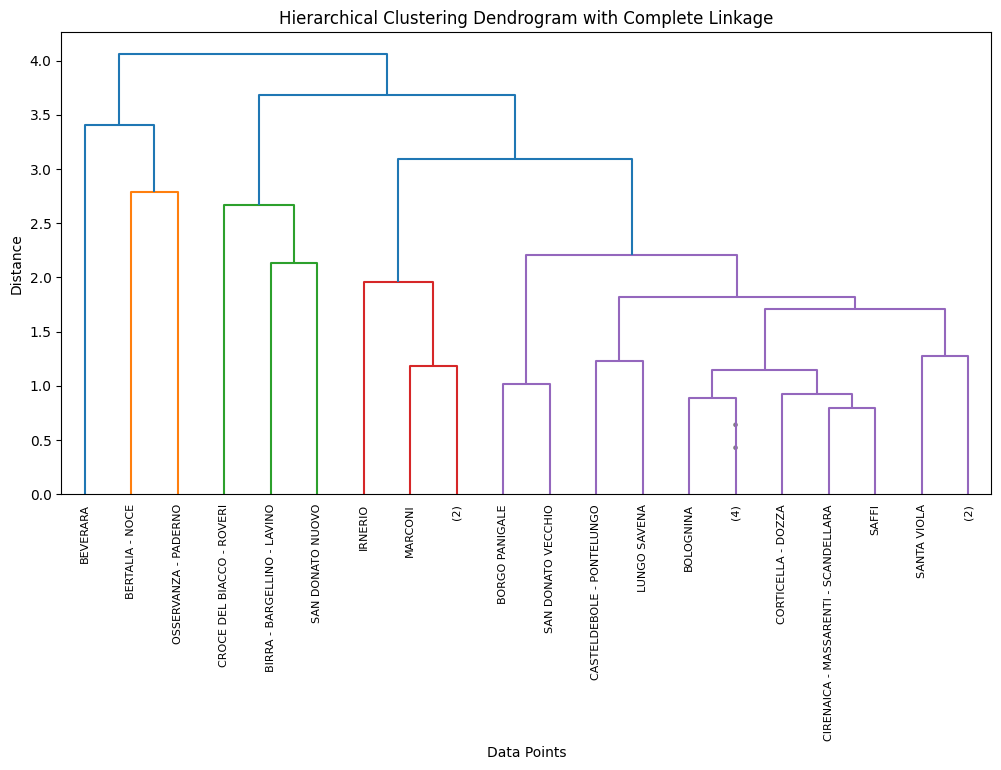

In [33]:
# repeat the hierarchical clustering from above but only with the transport related metrics
linkage_matrix = linkage(df_z_transport, method='average', metric='euclidean')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True, labels=df_z_transport.index)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()